In [2]:
import pandas as pd
df = pd.read_csv('dataset/self_made/pure_sin_p96.csv')

In [3]:
df

date         OT
0      2016-07-01 00:00:00   0.000000
1      2016-07-01 00:15:00   3.270156
2      2016-07-01 00:30:00   6.526310
3      2016-07-01 00:45:00   9.754516
4      2016-07-01 01:00:00  12.940952
...                    ...        ...
69675  2018-06-26 18:45:00 -49.039264
69676  2018-06-26 19:00:00 -48.296291
69677  2018-06-26 19:15:00 -47.346506
69678  2018-06-26 19:30:00 -46.193977
69679  2018-06-26 19:45:00 -44.843637

[69680 rows x 2 columns]

In [4]:
import plotly.graph_objects as go

In [5]:
fig = go.Figure()

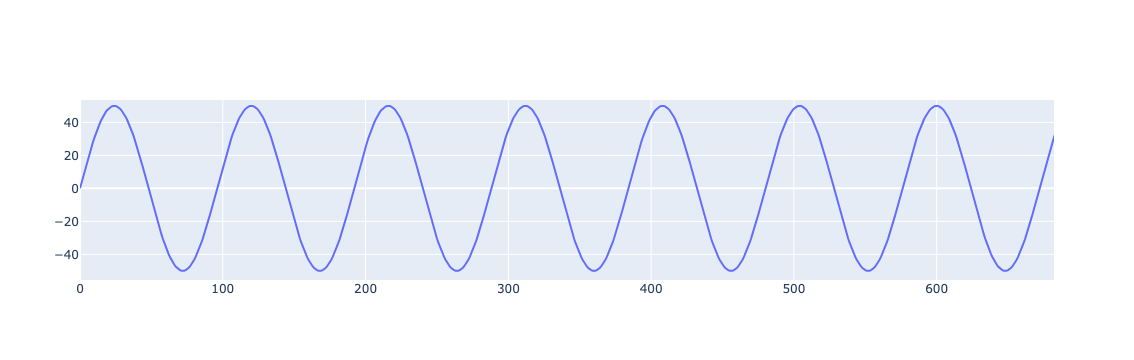

In [6]:
fig.add_trace(go.Scatter(y=df['OT'], mode='lines', name='data'))

In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
def read_data(root_path: str = "./dataset/ETT-small/", 
              data_path: str = "ETTm2.csv",
              seq_len: int = 96,
              set_type: int = 2, # test
              features: str = 'S',
              target: str = 'OT',
              scale: bool = True,
              timeenc: int = 0,
              freq: int = None,
             ):
    scaler = StandardScaler()
    df_raw = pd.read_csv(os.path.join(root_path,
                                      data_path))
    # 24*4 is one day's data, 15min/per data,
    # 12 is one year
    border1s = [0,

                # (   34560  )
                # 1 year - seq_len
                12 * 30 * 24 * 4 - seq_len,

                # (             46080             )
                # 1 year + 4 month
                12 * 30 * 24 * 4 + 4 * 30 * 24 * 4 - seq_len]

    #           (     34560    )
    border2s = [12 * 30 * 24 * 4,

                # (             46080             )
                # 1 year + 4 month = 15 months
                12 * 30 * 24 * 4 + 4 * 30 * 24 * 4,

                # 1 year + 8 month = 20 months
                12 * 30 * 24 * 4 + 8 * 30 * 24 * 4]

    # for non stationary training
    # border1s = [0, 700 - seq_len, 850 - seq_len]
    # border2s = [700, 850, 995]
    #
    # #10 k non-stationary
    # border1s = [0, 9000 - seq_len, 9500 - seq_len]
    # border2s = [9000, 9500, 9990]

    # for val, 1
    # 1 year - seq_len
    border1 = border1s[set_type]

    # 1 year + 4 month = 15 months
    border2 = border2s[set_type]

    if features == 'M' or features == 'MS':
        cols_data = df_raw.columns[1:]  # no heading
        df_data = df_raw[cols_data]
    elif features == 'S':
        # for univariate, this is "OT"
        df_data = df_raw[[target]]
    if scale:
        train_data = df_data[border1s[0]:border2s[0]]
        scaler.fit(train_data.values)
        data = scaler.transform(df_data.values)
    else:
        data = df_data.values
    # for train: 1 years data
    # or val: 4 month after 1 year
    df_stamp = df_raw[['date']][border1:border2]
    df_stamp['date'] = pd.to_datetime(df_stamp.date)
    if timeenc == 0:
        df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
        df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
        df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
        df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
        df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
        df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
        data_stamp = df_stamp.drop(['date'], axis=1).values
    elif timeenc == 1:
        data_stamp = time_features(pd.to_datetime(df_stamp['date'].values), freq=freq)
        data_stamp = data_stamp.transpose(1, 0)

    data_x = data[border1:border2]
    data_y = data[border1:border2]
    data_stamp = data_stamp
    return data_x, data_y, data_stamp, scaler

def tensor_2_df(start_date: str, 
                batch_to_convert, 
                scaler, 
                col_name:str = "value", 
                unscale: bool = True,
                freq:str = '15min',
                input_type:str = "tensor"
               ):
    """
    convert the output of the model to a dataframe
    process:
        1. remove the extra demension
        2. convert to numpy
        3. unscale the data, optional
        4. put the date
    """
    import pandas as pd
    if input_type == "tensor":
        squ_tensor = batch_to_convert.squeeze(0)
        np_tensor = squ_tensor.detach().numpy()
    elif input_type == "ndarray":
        np_tensor = pd.DataFrame(batch_to_convert, columns=[col_name])
    if unscale:
        unscaled_np_tensor = scaler.inverse_transform(np_tensor)
    else: 
        unscaled_np_tensor = np_tensor
    df_tensor = pd.DataFrame(unscaled_np_tensor, columns=[col_name])

        
    date_range = pd.date_range(start=start_date, periods=len(df_tensor), freq='15min')
    df_tensor['date'] = date_range
    df_tensor = df_tensor[['date', col_name]]
    return df_tensor

def getitem(index: int,
            data_x,
            data_y,
            data_stamp,
            pred_len: int = 96,
            seq_len: int = 96,
            label_len: int = 96,):
    s_begin = index
    s_end = s_begin + seq_len
    r_begin = s_end - label_len
    r_end = r_begin + label_len + pred_len

    seq_x = data_x[s_begin:s_end] # length is seq_len
    seq_y = data_y[r_begin:r_end] # length = label_len + pred_len
    seq_x_mark = data_stamp[s_begin:s_end]
    seq_y_mark = data_stamp[r_begin:r_end]

    return seq_x, seq_y, seq_x_mark, seq_y_mark


def predict(batch_x, 
             batch_y, 
             batch_x_mark, 
             batch_y_mark,
             model,
             device,
             pred_len: int = 720,
             label_len: int = 96,
             output_attention: bool = False,
             use_amp: bool = False,
             features: str = "S",
            ):
    """
    extracted from source code
    """
    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float() # mask
    dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
    # encoder - decoder

    def _run_model():
        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        if output_attention:
            outputs = outputs[0]
        return outputs

    if use_amp:
        with torch.cuda.amp.autocast():
            outputs = _run_model()
    else:
        outputs = _run_model()

    f_dim = -1 if features == 'MS' else 0
    outputs = outputs[:, -pred_len:, f_dim:]
    batch_y = batch_y[:, -pred_len:, f_dim:].to(device)

    return outputs, batch_y

# batch_x, batch_y, batch_x_mark, batch_y_mark = [seq_x], [seq_y], [seq_x_mark], [seq_y_mark]
def get_batch(raw_data):
    """
    simulate the dataloader process but when use only 1 vector, batch should have length 1
    """
    batched = torch.tensor(raw_data, dtype=torch.float32)
    batched = batched.unsqueeze(0)
    return batched

import torch
from models import Autoformer

def visualize_output(df_correct, prediction_data):
    import plotly.graph_objects as go
    highlight_length = 5
    fig = go.Figure(go.Scatter(x=df_correct['date'], 
                               y=df_correct['correct'], 
                               mode='lines', 
                               name='Correct Data'))
    fig.add_trace(go.Scatter(x=df_correct['date'][:95], 
                             y=df_correct['correct'][:95],
                             mode='lines', name='Used for Prediction', 
                             line=dict(color='orange', width=4, dash='dot')))
    fig.add_trace(go.Scatter(x=prediction_data['date'], y=prediction_data['predicted_result'],
                         mode='lines', name='Predicted Data', line=dict(color='red')))
    fig.update_layout(title='Correct vs Predicted Data',
                  xaxis_title='Timestamp',
                  yaxis_title='Value',
                  legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))
    fig.show()

In [5]:
from argparse import Namespace
configs = Namespace(
    is_training=1, 
    model_id='ETTm2_1000_500', 
    model='Autoformer', 
    data='ETTm2', 
    root_path='./dataset/ETT-small/', 
    data_path='ETTm2.csv', 
    features='S', 
    target='OT', 
    freq='t', 
    checkpoints='./checkpoints/', 
    seq_len=1000, 
    label_len=500, 
    pred_len=500, 
    bucket_size=4, 
    n_hashes=4, 
    enc_in=1, 
    dec_in=1, 
    c_out=1, 
    d_model=512, 
    n_heads=8, 
    e_layers=2, 
    d_layers=1, 
    d_ff=2048, 
    moving_avg=25, 
    factor=3, 
    distil=True, 
    dropout=0.05, 
    embed='timeF', 
    activation='gelu', 
    output_attention=False, 
    do_predict=False, 
    num_workers=10, 
    itr=1, 
    train_epochs=10, 
    batch_size=32, 
    patience=3, 
    learning_rate=0.0001, 
    des='Exp', 
    loss='mse', 
    lradj='type1', 
    use_amp=False, 
    use_gpu=True, 
    gpu=0, 
    use_multi_gpu=False, 
    devices='0,1,2,3'
)

In [6]:
data_x, data_y, data_stamp, scaler = read_data(set_type = 0, root_path = "dataset/self_made/", data_path = "pure_sin_p96.csv")

/var/folders/l7/_k2kxj9n5m5fnj95rbr69_dh0000gn/T/ipykernel_2977/3983424478.py:71: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
/var/folders/l7/_k2kxj9n5m5fnj95rbr69_dh0000gn/T/ipykernel_2977/3983424478.py:72: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
/var/folders/l7/_k2kxj9n5m5fnj95rbr69_dh0000gn/T/ipykernel_2977/3983424478.py:73: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
/var/folders/l

In [7]:
model_path = "/Users/ray/rayfile/self-project/hpc_files_backup/autoformer_changedsinplace/Autoformer/checkpoints/s1000_l500_p500_pa20_tp20_des-diff_label_input_Autoformer_ETTm2_ftS_sl1000_ll500_pl500_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/checkpoint.pth"

In [8]:
af = Autoformer.Model(configs)

In [9]:
af.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [42]:
seq_x, seq_y, seq_x_mark, seq_y_mark = getitem(index = 20, 
                                               data_x = data_x,
                                               data_y = data_y,
                                               data_stamp = data_stamp,
                                               label_len=500,
                                               seq_len=1000,
                                               pred_len = 500)
batch_x = get_batch(seq_x)
batch_y = get_batch(seq_y)
batch_x_mark = get_batch(seq_x_mark)
batch_y_mark = get_batch(seq_y_mark)

In [43]:
seq_x, seq_y, seq_x_mark, seq_y_mark = getitem(index = 21, 
                                               data_x = data_x,
                                               data_y = data_y,
                                               data_stamp = data_stamp,
                                               label_len=500,
                                               seq_len=1000,
                                               pred_len = 500)
batch_x_2= get_batch(seq_x)
batch_y_2 = get_batch(seq_y)
batch_x_mark_2 = get_batch(seq_x_mark)
batch_y_mark_2 = get_batch(seq_y_mark)

In [44]:
fake_test_loader = [(batch_x, batch_y, batch_x_mark, batch_y_mark),
                   (batch_x_2, batch_y_2, batch_x_mark_2, batch_y_mark_2)]

In [45]:
af.eval()

Model(
  (decomp): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (enc_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=5, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding_wo_pos(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=5, out_features=512, bias=False)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encode

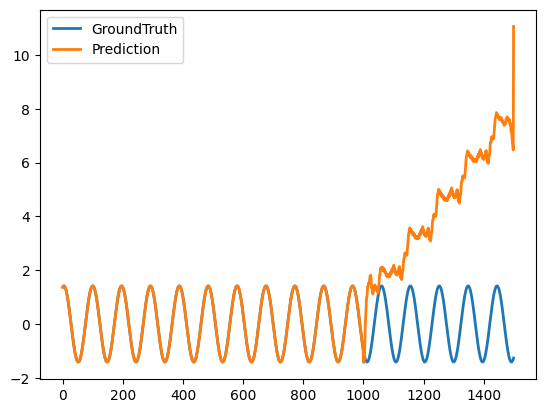

In [56]:
preds = []
trues = []
import numpy as np
import matplotlib.pyplot as plt

def visual(true, preds=None, name='./pic/test.pdf'):
    """
    Results visualization
    """
    plt.figure()
    plt.plot(true, label='GroundTruth', linewidth=2)
    if preds is not None:
        plt.plot(preds, label='Prediction', linewidth=2)
    plt.legend()
    plt.savefig(name, bbox_inches='tight')

with torch.no_grad():
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(fake_test_loader):
        batch_x = batch_x.float().to(torch.device('cpu'))
        batch_y = batch_y.float().to(torch.device('cpu'))

        batch_x_mark = batch_x_mark.float().to(torch.device('cpu'))
        batch_y_mark = batch_y_mark.float().to(torch.device('cpu'))

        outputs, batch_y = predict(batch_x, batch_y, batch_x_mark, batch_y_mark, af, torch.device('cpu'), pred_len = 500, label_len = 500)

        outputs = outputs.detach().cpu().numpy()
        batch_y = batch_y.detach().cpu().numpy()

        pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
        true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()

        preds.append(pred)
        trues.append(true)
        if i % 20 == 0:
            input = batch_x.detach().cpu().numpy()
            gt = np.concatenate((input[0, :, -1], true[0, :, -1]), axis=0)
            pd = np.concatenate((input[0, :, -1], pred[0, :, -1]), axis=0)
            visual(gt, pd, os.path.join("testing_output/", str(i) + '.pdf'))


In [77]:
inputs = []
with torch.no_grad():
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(fake_test_loader):
        input = batch_x.detach().cpu().numpy()
        inputs.append(input)

inputs_save = np.concatenate(inputs, axis=0)
inputs_save = inputs_save.reshape(-1, inputs_save.shape[-2], inputs_save.shape[-1])

In [78]:
inputs_save.shape

(2, 1000, 1)

In [74]:
preds_2[0][0, :, -1][:5]

array([-1.3990746 , -1.4318738 , -1.4019432 , -1.3087924 , -0.98461485],
      dtype=float32)

In [71]:
gt[:5], pd[:5]

(array([1.3660254, 1.3870399, 1.4021147, 1.4111856, 1.4142135],
       dtype=float32),
 array([1.3660254, 1.3870399, 1.4021147, 1.4111856, 1.4142135],
       dtype=float32))

In [57]:
preds_save = preds
trues_save = trues

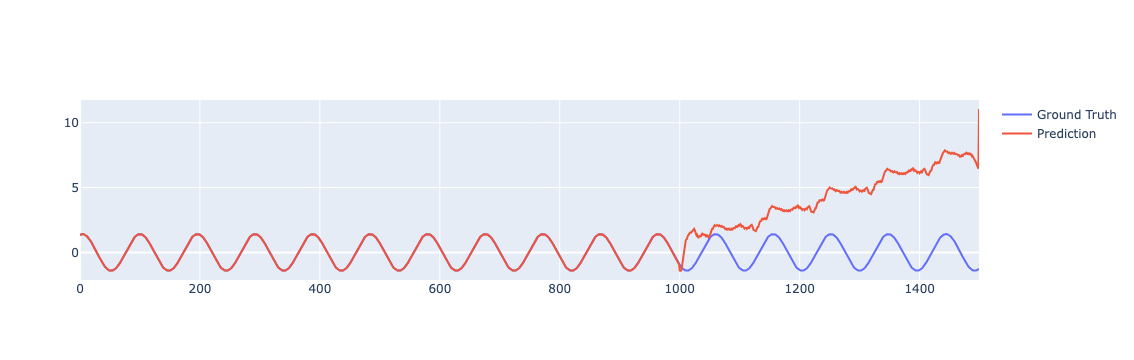

In [84]:
preds_save[0][0][:5], trues_save[0][0][:5]

import plotly.graph_objects as go
fig = go.Figure()

test_index = 0

# Add traces for true values and predictions
curr_true = np.squeeze(trues_save[test_index])
curr_pred = np.squeeze(preds_save[test_index])
curr_input = np.squeeze(inputs_save[test_index])

draw_true = np.concatenate((curr_input, curr_true))
draw_pred = np.concatenate((curr_input, curr_pred))
fig.add_trace(go.Scatter(y=draw_true, mode='lines', name='Ground Truth'))
fig.add_trace(go.Scatter(y=draw_pred, mode='lines', name='Prediction'))

In [82]:
curr_true

array([-1.00000000e+00, -1.06326210e+00, -1.12197101e+00, -1.17587554e+00,
       -1.22474492e+00, -1.26836956e+00, -1.30656302e+00, -1.33916140e+00,
       -1.36602545e+00, -1.38703990e+00, -1.40211475e+00, -1.41118562e+00,
       -1.41421354e+00, -1.41118562e+00, -1.40211475e+00, -1.38703990e+00,
       -1.36602545e+00, -1.33916140e+00, -1.30656302e+00, -1.26836956e+00,
       -1.22474492e+00, -1.17587554e+00, -1.12197101e+00, -1.06326210e+00,
       -1.00000000e+00, -9.32455778e-01, -8.60918641e-01, -7.85694957e-01,
       -7.07106769e-01, -6.25490665e-01, -5.41196108e-01, -4.54584062e-01,
       -3.66025418e-01, -2.75899380e-01, -1.84591904e-01, -9.24939960e-02,
       -1.38651255e-14,  9.24939960e-02,  1.84591904e-01,  2.75899380e-01,
        3.66025418e-01,  4.54584062e-01,  5.41196108e-01,  6.25490665e-01,
        7.07106769e-01,  7.85694957e-01,  8.60918641e-01,  9.32455778e-01,
        1.00000000e+00,  1.06326210e+00,  1.12197101e+00,  1.17587554e+00,
        1.22474492e+00,  

In [48]:
preds = np.concatenate(preds, axis=0)
trues = np.concatenate(trues, axis=0)
print('test shape:', preds.shape, trues.shape)
preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
print('test shape:', preds.shape, trues.shape)

test shape: (2, 500, 1) (2, 500, 1)
test shape: (2, 500, 1) (2, 500, 1)


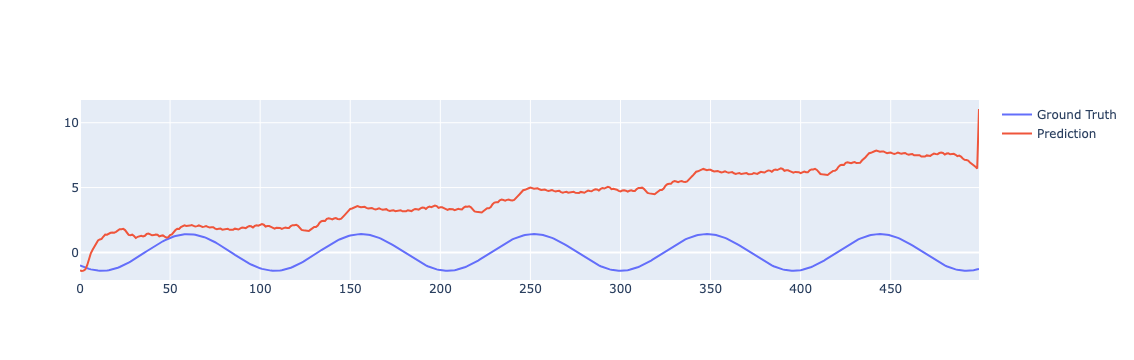

In [55]:
import plotly.graph_objects as go
fig = go.Figure()

test_index = 0

# Add traces for true values and predictions
fig.add_trace(go.Scatter(y=np.squeeze(trues[test_index]), mode='lines', name='Ground Truth'))
fig.add_trace(go.Scatter(y=np.squeeze(preds[test_index]), mode='lines', name='Prediction'))

In [54]:
preds[0][:5], trues[0][:5]

(array([[-1.3990746 ],
        [-1.4318738 ],
        [-1.4019432 ],
        [-1.3087924 ],
        [-0.98461485]], dtype=float32),
 array([[-1.       ],
        [-1.0632621],
        [-1.121971 ],
        [-1.1758755],
        [-1.2247449]], dtype=float32))